# Tutorial of network schematas - Bio Models
The network schematas for biological relevant boolean network models

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from __future__ import division
import os
import math
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:.2g}'.format
import graphviz
import cana
from cana.drawing import draw_canalizing_map_graphviz
import matplotlib as mpl
import matplotlib.style
mpl.style.use('classic')
import random
mpl.rc('font', **{'size':16})
import matplotlib.pyplot as plt
from cana.datasets.bio import THALIANA, DROSOPHILA, BUDDING_YEAST
from IPython.display import display, Image, Latex, SVG, HTML
import subprocess

In [4]:
def multi_column_display(objs, titles=['',''], cols=2):
    html_table = "<table style='width:100%; border:0px'>{content}</table>"
    html_row = "<tr style='border:0px'>{content}</tr>"
    html_cell = "<td style='width:{width}%;vertical-align:top;border:0px'><h3>{{title}}</h3>{{content}}</td>"
    html_cell = html_cell.format(width=100/cols)

    cells = [ html_cell.format(content=obj,title=title) for obj,title in zip(objs,titles) ]
    cells += (cols - (len(objs)%cols)) * [html_cell.format(content="",title="")] # pad
    rows = [ html_row.format(content="".join(cells[i:i+cols])) for i in range(0,len(cells),cols)]
    display(HTML(html_table.format(content="".join(rows))))

In [5]:
N = THALIANA()
#N = DROSOPHILA()
#N = BUDDING_YEAST()
print N

<BNetwork(Name='Arabidopsis Thaliana', N=15, Nodes=['AP3', 'UFO', 'FUL', 'FT', 'AP1', 'EMF1', 'LFY', 'AP2', 'WUS', 'AG', 'LUG', 'CLF', 'TFL1', 'PI', 'SEP'])>


## Effective Graph

In [6]:
Nsg = N.structural_graph()

In [29]:
# Node Position for each one of the models
nodes = {d['label']:i for i,d in Nsg.nodes(data=True)}
print nodes
att = {}
#
if N.name == 'Arabidopsis Thaliana':
    foldername = 'thaliana'
    
    # Calculates Node position in a circle. Used to plot nodes always in the same position.
    for deg,name in zip(range(0,360,30), ['AG', 'AP3', 'PI', 'AP2', 'TFL1', 'FUL', 'AP1', 'FT', 'EMF1', 'LFY', 'SEP', 'WUS']):
        r = 150
        x, y = r*math.cos(math.radians(deg)), r*math.sin(math.radians(deg))
        att[name] = {'x':x,'y':y}
    # Nodes not on the circle. Manually position them = UFO, LUG, CLF
    for name,(x,y) in zip(['UFO','LUG','CLF'], [(200.,140.),(240.,50.),(240.,-50.)]):
        att[name] = {'x':x,'y':y}

elif N.name == 'Drosophila Melanogaster':
    foldername = 'drosophila'
    
    x,y = np.linspace(0,500,8,dtype=int), np.linspace(500,0,8,dtype=int)
    att['nWG']    = {'x':x[5],'y':y[0],'fillcolor':'#4f6fb0'}
    att['SLP']    = {'x':x[7],'y':y[1],'fillcolor':'#4f6fb0'}
    att['en']     = {'x':x[5],'y':y[1]}
    att['EN']     = {'x':x[5],'y':y[2]}
    att['nhhnHH'] = {'x':x[1],'y':y[4]}
    att['ci']     = {'x':x[4],'y':y[3]}
    att['PTC']    = {'x':x[2],'y':y[4]}
    att['nhhnHH'] = {'x':x[2],'y':y[2],'fillcolor':'#4f6fb0'}
    att['CI']     = {'x':x[4],'y':y[4]}
    att['PH']     = {'x':x[0],'y':y[5]}
    att['SMO']    = {'x':x[1],'y':y[5]}
    att['CIA']    = {'x':x[3],'y':y[5]}
    att['CIR']    = {'x':x[4],'y':y[5]}
    att['ptc']    = {'x':x[3],'y':y[6]}
    att['wg']     = {'x':x[4],'y':y[6]}
    att['hh']     = {'x':x[6],'y':y[6]}
    att['WG']     = {'x':x[4],'y':y[7]}
    att['HH']     = {'x':x[6],'y':y[7]}

elif N.name == 'Budding Yeast Cell Cycle':
    foldername = 'yeast'
    
    # Calculates Node position in a circle.
    for deg,name in zip( np.linspace(0,360,10), ['Cln3','MBF','Clb5,6','Mcm1/SFF','Swi5','Cdc20/14','Cdh1','Cln1,2','SBF']):
        r = 190
        deg += 90
        x, y = r*math.cos(math.radians(deg)), r*math.sin(math.radians(deg))
        att[name] = {'x':x,'y':y}
    # Nodes not on the circle. Manually position them = UFO, LUG, CLF
    for name,(x,y) in zip(['CellSize','Sic1','Clb1,2'], [(0.,280.),(0.,100.),(0.,-50.)]):
        att[name] = {'x':x,'y':y}

{'WUS': 8, 'FT': 3, 'AG': 9, 'UFO': 1, 'AP2': 7, 'AP3': 0, 'CLF': 11, 'AP1': 4, 'SEP': 14, 'TFL1': 12, 'EMF1': 5, 'LUG': 10, 'FUL': 2, 'PI': 13, 'LFY': 6}


Nodes: 15 | Edges: 44


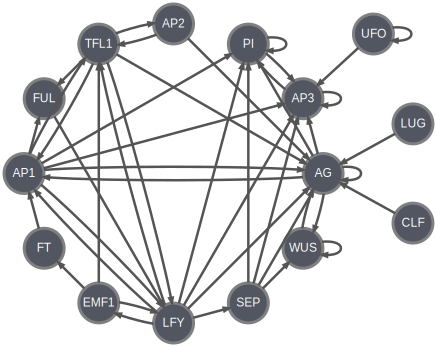

0

In [34]:
# Draw the Structural Graph
S = graphviz.Digraph(name='Structural Graph', engine='neato')
S.attr('graph', concentrate='false', simplify='false', overlap='false',splines='false')
S.attr('node', shape='circle', fixedsize='true', width='.55', color='gray', style='filled', fillcolor='#515660', penwidth='3', fontname='Helvetica', fontcolor='white',fontsize='12')
S.attr('edge', arrowhead='normal', arrowsize='.5', color='#545454')

for node,d in Nsg.nodes(data=True):
    if d['label'] in att:
        natt = att[d['label']]
        if 'x' in natt or 'y' in natt:
            x,y = natt['x'] , natt['y']
            xy = '%.2f,%.2f!' % (x/72,y/72)
        if 'fillcolor' in natt:
            fillcolor = natt['fillcolor']
        else:
            fillcolor = '#515660'
    else:
        xy = 'false'
        fillcolor = '#515660'
    S.node(name=str(node), label=d['label'], pos=xy, fillcolor=fillcolor)

max_penwidth = 2.5
for s,t,d in Nsg.edges(data=True):
    weight = '%d' % (d['weight']*100)
    penwidth_scaled = '%.2f' % ( (d['weight']/1)*max_penwidth )
    S.edge(str(s),str(t), weight=weight, penwidth=penwidth_scaled, )
print 'Nodes: %d | Edges: %d' % (len(Nsg.nodes()) , len(Nsg.edges()) )
# Display
display(SVG(S.pipe(format='svg')),metadata={'isolated':True})
# Export
S._format = 'svg'
efile = u"%s/../experiments/2017 - BioModels/%s/graphs/SG" % (os.getcwd(),foldername)
S.render(efile, cleanup=True)
subprocess.call("inkscape -z '%s.svg' -d 300 -e '%s.png'" % (efile,efile) , shell=True)

In [18]:
# Calculate Effective Graph
threshold = 0.00
Neg = N.effective_graph(mode='input',bound='upper', threshold=threshold)

Nodes: 15 | Edges: 41


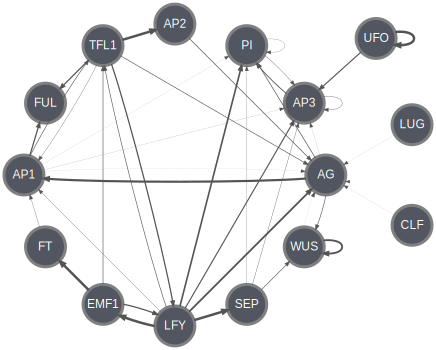

0

In [33]:
# Draw the Effective Graph
E = graphviz.Digraph(name='Effective Graph', engine='neato')
E.attr('graph', concentrate='false', simplify='false')
E.attr('node', shape='circle', fixedsize='true', width='.55', color='grey', style='filled', fillcolor='#515660', penwidth='3', fontname='Helvetica', fontcolor='white',fontsize='12')
E.attr('edge', arrowhead='normal', arrowsize='.5', color='#545454')

for node,d in Neg.nodes(data=True):
    if d['label'] in att:
        natt = att[d['label']]
        x,y = natt['x'],natt['y']
        xy = '%.1f,%.1f!' % (x/72,y/72)
        if 'fillcolor' in natt:
            fillcolor = natt['fillcolor']
        else:
            fillcolor = '#515660'
    else:
        xy = 'false'
    E.node(name=str(node), label=d['label'], pos=xy, fillcolor=fillcolor)

max_penwidth = 2.5
for s,t,d in Neg.edges(data=True):
    weight = '%d' % (d['weight']*100)
    penwidth_scaled = '%.2f' % ( (d['weight']/1)*max_penwidth )
    E.edge(str(s),str(t), weight=weight, penwidth=penwidth_scaled)
    
print 'Nodes: %d | Edges: %d' % (len(Neg.nodes()) , len(Neg.edges()) )
# Display
display(SVG(E.pipe(format='svg')),metadata={'isolated':True})
# Export
E._format = 'svg'
efile = u'%s/../experiments/2017 - BioModels/%s/graphs/EG' % (os.getcwd(),foldername)
E.render(efile, cleanup=True)
subprocess.call("inkscape -z '%s.svg' -d 300 -e '%s.png'" % (efile,efile) , shell=True)

In [29]:
bound = 'upper'
print N.nodes[1].schemata_look_up_table(type="ts")
df = pd.DataFrame({
        'node':[n.name for n in N.nodes],
        'k':[n.k for n in N.nodes],
        'k_r':[n.input_redundancy(mode='node',bound=bound,norm=False) for n in N.nodes],
        'k_e':[n.effective_connectivity(mode='node',bound=bound,norm=False) for n in N.nodes],
        'k_s':[n.input_symmetry(mode='node',bound=bound,norm=False) for n in N.nodes],
        'k_r*':[n.input_redundancy(mode='node',bound=bound,norm=True) for n in N.nodes],
        'k_e*':[n.effective_connectivity(mode='node',bound=bound,norm=True) for n in N.nodes],
        'k_s*':[n.input_symmetry(mode='node',bound=bound,norm=True) for n in N.nodes],
        'k_e(out-d)':[v for n,v in Neg.out_degree()],
        'k_e(out-s)':[v for n,v in Neg.out_degree(weight='weight')],
    }).set_index('node')
df = df[['k','k_r','k_e','k_s','k_r*','k_e*','k_s*','k_e(out-d)','k_e(out-s)']]
print df

  In:  Out:
0   0     0
1   1     1
      k  k_r  k_e  k_s  k_r*  k_e*  k_s*  k_e(out-d)  k_e(out-s)
node                                                            
AP3   7  4.8  2.2  3.5  0.69  0.31  0.51           2        0.48
UFO   1    0    1    0     0     1     0           2         1.5
FUL   2 0.75  1.2    2  0.38  0.62     1           0           0
FT    1    0    1    0     0     1     0           1        0.12
AP1   4  2.4  1.6  1.9  0.61  0.39  0.47           5        0.85
EMF1  1    0    1    0     0     1     0           3         1.8
LFY   4  2.8  1.2    2  0.69  0.31   0.5           7         4.2
AP2   1    0    1    0     0     1     0           1        0.27
WUS   3  1.5  1.5  1.3   0.5   0.5  0.44           2        0.77
AG    9  6.9  2.1  3.4  0.77  0.23  0.38           5         1.5
LUG   0    0    1    0     0     1     0           1       0.023
CLF   0    0    1    0     0     1     0           1       0.023
TFL1  4  2.8  1.2    2  0.69  0.31   0.5           5  

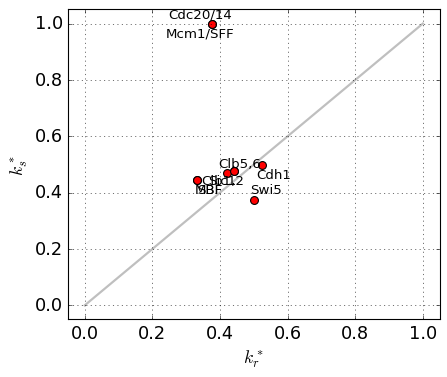

In [14]:
fig, ax = plt.subplots(1,1,figsize=(6,5), sharex=True, sharey=True)
dfp = df.loc[ (df['k']>1) , :]
ax.scatter(dfp['k_r*'],dfp['k_s*'], s=50, c='red', marker='o', zorder=2)
lx,ly = [],[]
quadrants = [-0.035,0.035]
for name, dfp_ in dfp.iterrows():
    x,y = dfp_['k_r*']+random.choice(quadrants) , dfp_['k_s*']+random.choice(quadrants)
    ax.annotate(name, (x,y),fontsize=12, va='center', ha='center')
    lx.append(x); ly.append(y)
ax.plot((0,1),(0,1),'black', lw=2,alpha=0.25, zorder=1)
ax.grid(True)
ax.set_xlim(-0.05,1.05)
ax.set_ylim(-0.05,1.05)
ax.set_xlabel('$k_r^*$')
ax.set_ylabel('$k_s^*$')
plt.savefig('../experiments/2017 - BioModels/%s/plots/k_sn_vs_k_rn.png' % (foldername), dpi=150)

In [10]:
#df = df.loc[ (df['k']>1) , :]
print df.sort_values('k',ascending=False).to_latex()
"""
multi_column_display([
        df[['k']].sort_values('k',ascending=False).to_html(),
        df[['k_r']].sort_values('k_r',ascending=False).to_html(),
        df[['k_e']].sort_values('k_e',ascending=False).to_html(),
        df[['k_s']].sort_values('k_s',ascending=False).to_html(),
        df[['k_r*']].sort_values('k_r*',ascending=False).to_html(),
        df[['k_e*']].sort_values('k_e*',ascending=False).to_html(),
        df[['k_s*']].sort_values('k_s*',ascending=False).to_html(),
        df[['k_e(out-d)']].sort_values('k_e(out-d)',ascending=False).to_html(),
        df[['k_e(out-s)']].sort_values('k_e(out-s)',ascending=False).to_html()
    ],['k','k_r','k_e','k_s','k_r*','k_e*','k_s*','k_e(out-d)','k_e(out-s)'],7 )
"""

NameError: name 'df' is not defined

Inputs: ['CellSize']
CM: CellSize


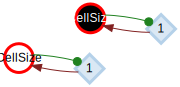

Inputs: ['CellSize']
CM: Cln3


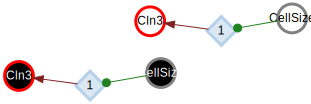

Inputs: ['Cln3', 'SBF', 'Clb1,2']
CM: SBF


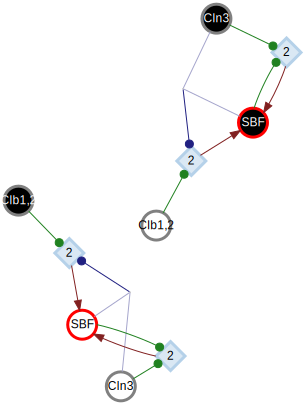

Inputs: ['Cln3', 'MBF', 'Clb1,2']
CM: MBF


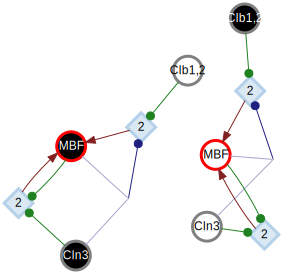

Inputs: ['SBF']
CM: Cln1,2


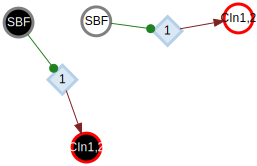

Inputs: ['Cln1,2', 'Sic1', 'Clb5,6', 'Clb1,2', 'Cdc20/14', 'Swi5']
CM: Sic1


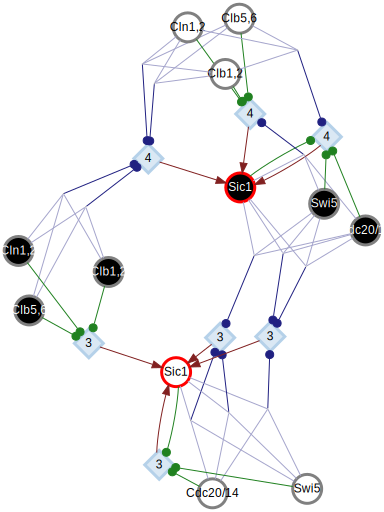

Inputs: ['MBF', 'Sic1', 'Clb5,6', 'Cdc20/14']
CM: Clb5,6


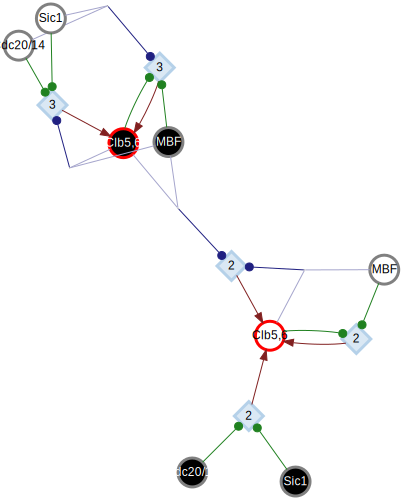

Inputs: ['Cln1,2', 'Clb5,6', 'Cdh1', 'Clb1,2', 'Cdc20/14']
CM: Cdh1


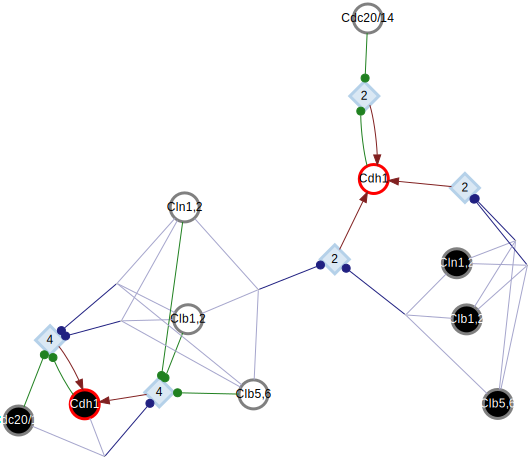

Inputs: ['Sic1', 'Clb5,6', 'Cdh1', 'Clb1,2', 'Mcm1/SFF', 'Cdc20/14']
CM: Clb1,2


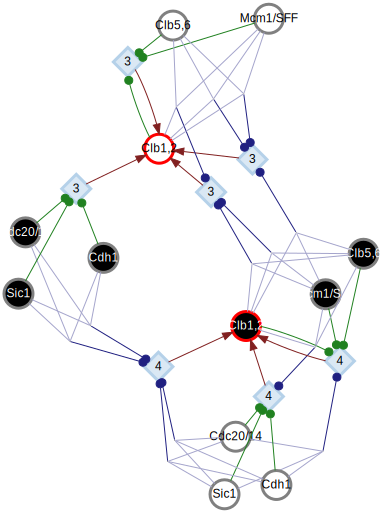

Inputs: ['Clb5,6', 'Clb1,2']
CM: Mcm1/SFF


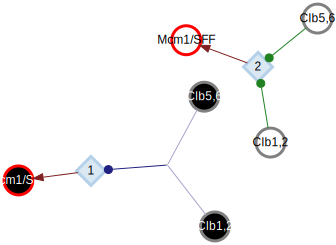

Inputs: ['Clb1,2', 'Mcm1/SFF']
CM: Cdc20/14


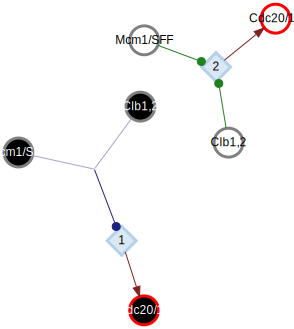

Inputs: ['Clb1,2', 'Mcm1/SFF', 'Cdc20/14', 'Swi5']
CM: Swi5


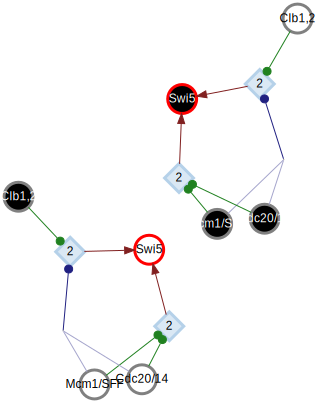

In [17]:
bound = 'upper'
for i,n in enumerate(N.nodes):
    display(HTML('<h2>'+n.name+'</h2>'))
    print 'Inputs:',n.inputs
    k = n.k
    k_r = n.input_redundancy(mode='node',bound=bound,norm=False)
    k_r_n = n.input_redundancy(mode='node',bound=bound,norm=True)
    k_e = n.effective_connectivity(mode='node', bound=bound, norm=False)
    k_s = n.input_symmetry(mode='node',bound=bound,norm=False)
    k_s_n = n.input_symmetry(mode='node',bound=bound,norm=True)
    
    dfS = pd.DataFrame([('k',k),('k_r',k_r),('k_e',k_e),('k_s',k_s),('k_r*',k_r_n),('k_s*',k_s_n)]).set_index(0).T
    #display(dfS)
    
    pi = n.schemata_look_up_table(type='pi',format='latex', ts_symbol_latex="\circ")
    ts = n.schemata_look_up_table(type='ts',format='latex', ts_symbol_latex="\circ")
    #display(Latex(pi))
    #display(Latex(ts))
    #multi_column_display([pi,ts],titles=['Prime Implicants','Two-Symbol Schemtas'],cols=4)

    # to make sure each SVG renders independently, add the "metadata={'isolated':True}
    CM = n.canalizing_map()
    gv = draw_canalizing_map_graphviz(CM)
    print CM
    display(SVG(gv.pipe(format='svg')),metadata={'isolated':True})

    # Export to .SVG
    filename = n.name
    filename = filename.replace(',','_')
    filename = filename.replace('/','_')
    gv._format = 'svg'
    efile = u'%s/../experiments/2017 - BioModels/%s/CM/%s-%s' % (os.getcwd(),foldername,i,filename)
    gv.render(efile, cleanup=True)
    subprocess.call("inkscape -z -d 150 '%s.svg' -e '%s.png'" % (efile,efile) , shell=True)

    #break